### Import required libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load & Read Data

In [32]:
df=pd.read_csv('D:\PGP IN DATA SCIENCE with Careerera\Data Sets\data-for-time-series\\Tractor-Sales.csv')
df

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
...,...,...
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519


In [3]:
df.shape

(144, 2)

In [4]:
df.size

288

In [5]:
df.columns

Index(['Month-Year', 'Number of Tractor Sold'], dtype='object')

In [6]:
df.dtypes

Month-Year                object
Number of Tractor Sold     int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df.describe(percentiles=[0.10,0.25,0.50,0.75,0.95,0.99])

,Number of Tractor Sold
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
10%,196.300000
25%,248.500000
50%,369.000000
75%,509.250000
95%,706.850000
99%,824.350000


In [33]:
df['Date']=pd.to_datetime(df['Month-Year'], format='%b-%y')
df.head()

,Month-Year,Number of Tractor Sold,Date
0,Jan-03,141,2003-01-01
1,Feb-03,157,2003-02-01
2,Mar-03,185,2003-03-01
3,Apr-03,199,2003-04-01
4,May-03,203,2003-05-01


In [34]:
ts=df.drop('Month-Year', axis=1)
ts.rename({'Number of Tractor Sold':'Sales'},axis=1, inplace=True)
ts.set_index('Date', inplace=True)
ts.head()

,Sales
Date,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


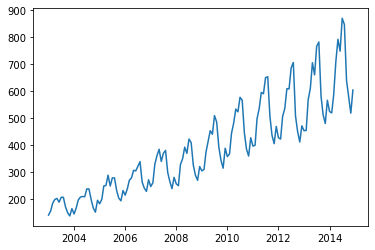

In [11]:
plt.plot(ts);

### Stationary Check

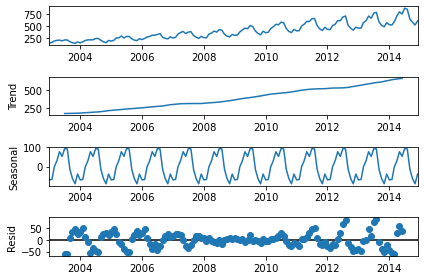

In [12]:
import statsmodels.api as sm
decomposition=sm.tsa.seasonal_decompose(ts,model='additive')
fig=decomposition.plot();

In [13]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(ts)
print("p-value", adf_test[1])

p-value 0.9952912415248419


p-value is greater than 0.05 hence series is not stationary.

#### Train Test split

In [14]:
ts.shape

(144, 1)

In [35]:
train=ts[:132]
test=ts[132:]
print(train.shape)
print(test.shape)

(132, 1)
(12, 1)


#### Hyperparameter of ARIMA model p,d,q

* **AR oeder we get "p"**
* **MA order we get "q"**
* **Integrated order we get "d"**

#### Biuld ARIMA model

In [38]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train, order=(5,0,4)).fit()

#### Prediction

In [17]:
len(train),len(ts)

(132, 144)

In [40]:
pred=model.predict(start=len(train), end=len(ts)-1)
pred

2014-01-01     586.682205
2014-02-01     584.769672
2014-03-01     650.396897
2014-04-01     737.146185
2014-05-01     759.652179
2014-06-01     763.898237
2014-07-01     830.936265
2014-08-01     914.980331
2014-09-01     938.976118
2014-10-01     948.362787
2014-11-01    1016.303430
2014-12-01    1097.719768
Freq: MS, dtype: float64

#### Evaluate model

In [41]:
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test,pred))
print("RMSE", RMSE)

RMSE 247.42119888317936


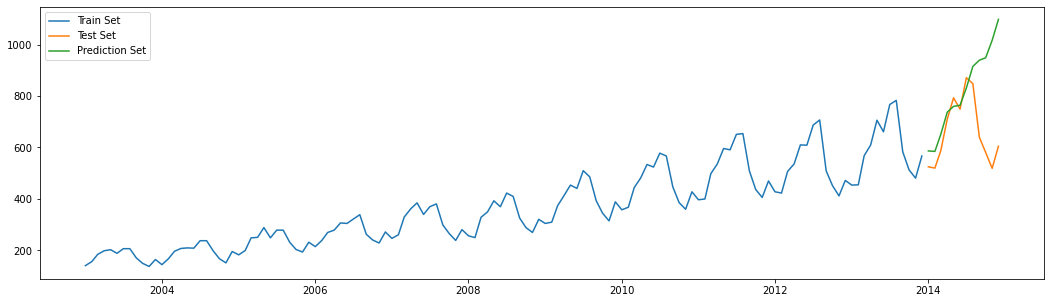

In [42]:
plt.figure(figsize=(18,5))
plt.plot(train, label="Train Set")
plt.plot(test, label="Test Set")
plt.plot(pred, label="Prediction Set")
plt.legend();

#### Hyperparameter selection

In [46]:
import itertools
p=range(0,8)
q=range(0,8)
d=range(0,2)
pdq=list(itertools.product(p,d,q))
len(pdq)

128

In [47]:
len(ts)

144

In [49]:
rmse=[]
order1=[]
for pdq in pdq:
    try:
        model=ARIMA(train, order=pdq).fit()
        pred=model.predict(start=len(train), end=len(ts)-1)
        error=np.sqrt(mean_squared_error(pred,test))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [54]:
results=pd.DataFrame(data=rmse, index=order1, columns=['RMSE'])
results

,RMSE
"(0, 0, 1)",318.218884
"(0, 0, 2)",317.470652
"(0, 0, 3)",315.614441
"(0, 0, 4)",302.915762
"(0, 0, 5)",291.659630
...,...
"(7, 0, 3)",84.937761
"(7, 1, 0)",671.217491
"(7, 1, 1)",671.919866
"(7, 1, 2)",670.990310


In [65]:
pd.pivot_table(results, values='RMSE', index=results.index, aggfunc=min).sort_values(by='RMSE', ascending=True)[:5]

,RMSE
"(7, 0, 0)",66.574682
"(7, 0, 3)",84.937761
"(5, 0, 5)",105.176455
"(3, 0, 5)",116.659292
"(4, 0, 7)",121.144588


At p=7, d=0, q=0 the RMSE is 66 which very low compared to any other RMSE. so choosing these value we build our ARIMA model.

In [66]:
model=ARIMA(train, order=(7,0,0)).fit()
pred=model.predict(start=len(train), end=len(ts)-1)
pred
RMSE=np.sqrt(mean_squared_error(test,pred))
print("RMSE", RMSE)

RMSE 66.57468243817414


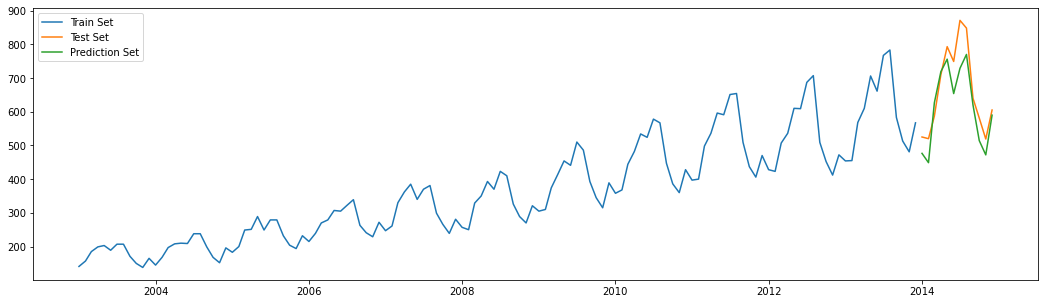

In [67]:
plt.figure(figsize=(18,5))
plt.plot(train, label="Train Set")
plt.plot(test, label="Test Set")
plt.plot(pred, label="Prediction Set")
plt.legend();